### Importing data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/task/

/content/gdrive/MyDrive/task


### Data preprocessing 
- dividing data into 4 folds
- using pycoco creator tools changing images and masks into standard coco notation

In [ ]:
!python data_preparation/organize2017_train.py --data-dir . --save-dir ./train --cropped
!python data_preparation/organize2017.py --data-dir .  --save-dir ./test --cropped


In [ ]:
!sudo apt-get install python3-dev
!pip install cython
!pip install git+git://github.com/waspinator/coco.git@2.1.0
!pip install git+git://github.com/waspinator/pycococreator.git@0.2.0

In [ ]:
!python ./data_preparation/robotseg_to_coco.py --image-dir ./train/fold1/images --anns-dir ./train/fold1/binary_annotations --save-dir ./train/fold1/new_annotations --dataset "2017" --group-name "split_test_1,3" --json-prefix "test_json"

Called with args:
Namespace(anns_dir='./train/fold1/binary_annotations', dataset='2017', group_name='split_test_1,3', image_dir='./train/fold1/images', json_prefix='test_json', save_dir='./train/fold1/new_annotations')
  0% 0/450 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pycococreatortools/pycococreatortools.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours = np.subtract(contours, 1)
100% 450/450 [06:54<00:00,  1.09it/s]


In [ ]:
f = open('./train/fold1/new_annotations/trial_json_split_2,4,5,6,7,8_1,3.json')
d = json.load(f)

In [ ]:
tt = open('train/fold1/new_annotations/json_split_test_1,3.json')
t = json.load(tt)

In [ ]:
segmentations = {}
for segmentation in test_file['annotations']:
  image_id = segmentation['image_id']
  if image_id not in segmentations:
    segmentations[image_id] = []
  segmentations[image_id].append(segmentation)


In [ ]:
images = {}
for image in test_file['images']:
  image_id = image['id']
  if image_id in images:
    print("ERROR: Skipping duplicate image id: {}".format(image))
  else:
    images[image_id] = image

In [ ]:
index_toremove=[]
for i in images.items():
  if i[0] in segmentations.keys():
    continue
  else:
    index_toremove.append(i[0])
    
for i in index_toremove:
  images.pop(i)

In [ ]:

for i, seg in enumerate(segmentations[1]):
  xmin, ymin, box_width, box_height = seg['bbox']
  box = [xmin, ymin, xmin+width, ymin+height]
  print(box)

[8.0, 407.0, 593.0, 239.0]
[370.0, 429.0, 903.0, 320.0]
[805.0, 148.0, 468.0, 167.0]


In [ ]:

for i, seg in enumerate(segmentations[1]):
  xmin, ymin, box_width, box_height = seg['bbox']
  box = [xmin, ymin, xmin+box_width, ymin+box_height]
  print(box)

[8.0, 407.0, 601.0, 646.0]
[370.0, 429.0, 1273.0, 749.0]
[805.0, 148.0, 1273.0, 315.0]


In [ ]:
images = []
for image in d['images']:
  image_id = image['id']
  if image_id in images:
    print("ERROR: Skipping duplicate image id: {}".format(image))
  else:
    images.append((image_id, image))

In [ ]:
segmentations = {}
for segmentation in d['annotations']:
  image_id = segmentation['image_id']
  if image_id not in segmentations:
    segmentations[image_id] = []
  segmentations[image_id].append(segmentation)

### Importing Libraries

In [3]:
import os 
import torch
import json
import numpy as np
from PIL import Image
from skimage.draw import polygon
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset

### Creating a custom dataset  class 

In [5]:
class seg_dataset(Dataset):
  def __init__(self, image_dir, json_file, transform=None):
    self.image_dir = image_dir
    self.transform = transform
    f = open(json_file)
    self.json_file = json.load(f)
    
    self.get_images()
    self.get_segments()
    self.remove_images()


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):

    def get_mask(seg, h, w):
      mask1 = np.zeros((h, w))
      for i in seg['segmentation']:
        x=[]
        y=[]
        for j in range(0,len(i),2):
          x.append(i[j])
          y.append(i[j+1])
        x = np.array(x)
        y = np.array(y)
        xs, ys = polygon(y,x, shape=(h, w))
        mask1[xs, ys] = 1
      return mask1
    
    def get_bbox(lst):
      x_min, y_min, box_width, box_height = lst['bbox']
      box = [x_min, y_min, x_min + box_width, y_min + box_height]
      return box

    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.images[idx]
    image_id = image[0]
    image_height = image[1]['height']
    image_width = image[1]['width']
    image_path = os.path.join(self.image_dir, image[1]['file_name'])
    image = Image.open(image_path).convert("RGB")
    labels=[]
    iscrowds=[]
    masks=[]
    boxes=[]
    areas=[]
    
    for i, seg in enumerate(self.segmentations[image_id]):
      box = get_bbox(seg)
      boxes.append(box)
      label = seg['category_id']
      labels.append(label)
      mask = get_mask(seg, image_height, image_width)
      mask = mask
      masks.append(mask)
      area = seg['area']
      areas.append(area)
      iscrowd = seg['iscrowd']
      iscrowds.append(iscrowd)
    
    target={}
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
    target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
    target["image_id"] = torch.as_tensor([image_id])
    target["area"] = torch.as_tensor(areas, dtype=torch.float32)
    target["iscrowd"] = torch.as_tensor(iscrowds, dtype=torch.float32)

    if self.transform is not None:
      image, target = self.transform(image, target)

    return image, target
    
  def get_segments(self):
    self.segmentations = {}
    for segmentation in self.json_file['annotations']:
      image_id = segmentation['image_id']

      if image_id not in self.segmentations:
        self.segmentations[image_id] = []
      self.segmentations[image_id].append(segmentation)

  def get_images(self):
    self.images = []
    for image in self.json_file['images']:
      image_id = image['id']
      if image_id in self.images:
        print("ERROR: Skipping duplicate image id: {}".format(image))
      else:
        self.images.append((image_id, image))

  def remove_images(self):
    index_to_remove=[]
    for i in self.images:
      if i[0] in self.segmentations.keys():
        continue
      else:
        index_to_remove.append(i)
    for idx in index_to_remove:
      self.images.remove(idx)
    



In [6]:
test = seg_dataset('train/fold1/images', 'train/fold1/new_annotations/json_split_test_1,3.json')
data = seg_dataset('train/fold0/images', 'train/fold0/new_annotations/trial_json_split_2,4,5,6,7,8_1,3.json')

### Creating Model

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [13]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [14]:
dataset = seg_dataset('train/fold0/images', 'train/fold0/new_annotations/trial_json_split_2,4,5,6,7,8_1,3.json', get_transform(train=True))
dataset_test = seg_dataset('train/fold1/images', 'train/fold1/new_annotations/json_split_test_1,3.json', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 8
model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


### Training

In [ ]:
num_epochs = 1
fold = 0
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10, epoch_max=num_epochs, fold=fold)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [ ]:
test_image, test_target = (next(iter(data_loader_test)))
test_image = test_image[0].numpy()
test_image = np.rollaxis(test_image, -1, 1)
inputs = list(j.to(device) for j in test_image)
pred = model(inputs)
pred_mask = pred[0]['masks']

In [ ]:
sum_m =0
for i in pred_mask:
  i = i.cpu().detach().numpy()
  i = np.rollaxis(i, 0, -1)
  i = np.rollaxis(i, -1, 1)
  sum_m += i

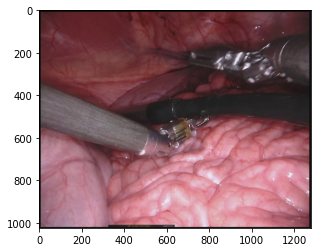

In [ ]:
plt.imshow(test_image)

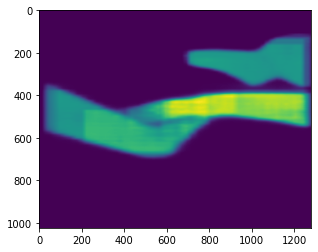

In [ ]:
plt.imshow(sum_m.squeeze())